In [1]:
import os
import gzip
import shutil
import requests

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from ctd import get_data
from ctd.utils import get_disease_hierarchy

from src.disease_classifier import DiseaseClassifier

In [2]:
input_df = get_data('ChemicalDiseaseInteractions')

/opt/conda/lib/python3.11/site-packages/ctd/get_data.py:103: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(the_file, skiprows=29, names=header)


## No class weights or over sampling

374/374 [==============================] - 1s 2ms/step


,loss,tp,fp,tn,fn,accuracy,precision,recall,auc,prc,parent_disease,gene_count,show_plots,use_class_weights,oversample,model_type
0,0.025432,55.0,2.0,11833.0,55.0,0.995228,0.964912,0.5,0.902723,0.679789,MESH:D019636,100,True,False,False,DNN


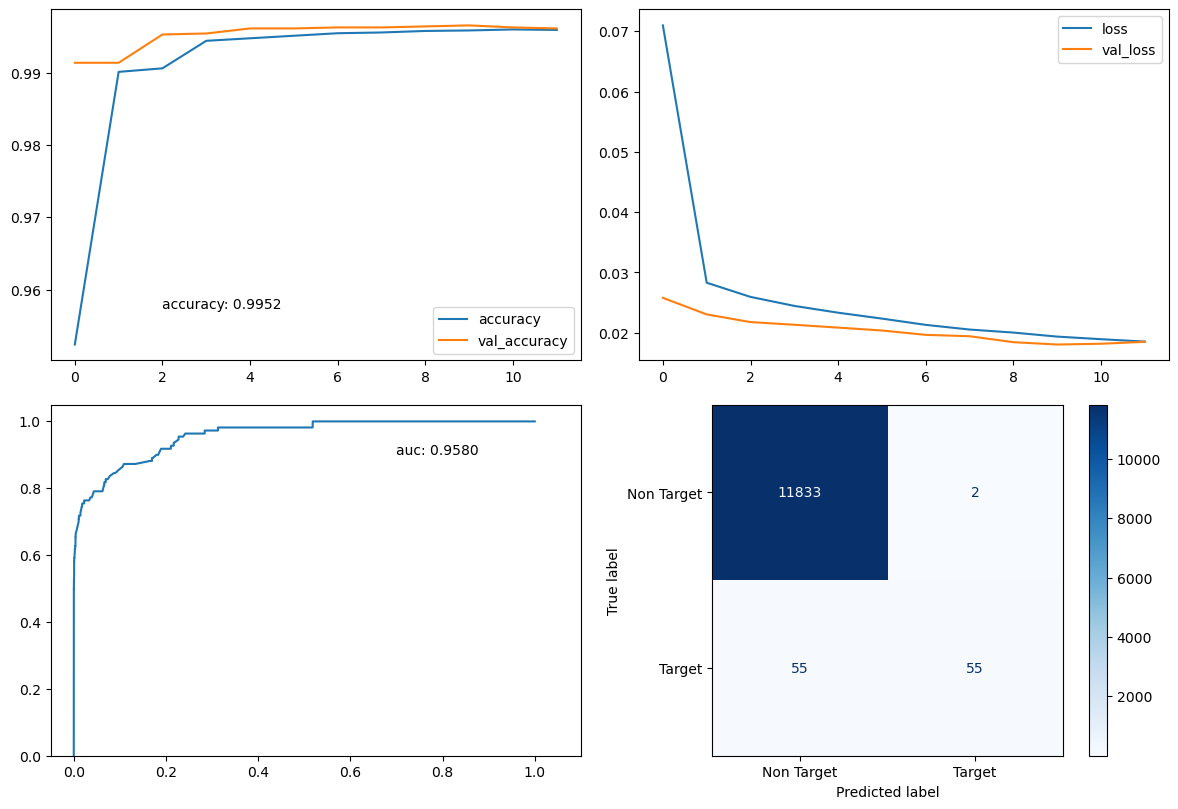

In [5]:
kw = {
    'input_df': input_df,
    'parent_disease': 'MESH:D019636', # neurodegenerative diseases
    'gene_count': 100,
    'show_plots': True,
    'use_class_weights': False,
    'oversample': False
}
dc = DiseaseClassifier(**kw)
dc_mm, _ = dc.main()

## Class Weights

374/374 [==============================] - 1s 1ms/step


,loss,tp,fp,tn,fn,accuracy,precision,recall,auc,prc,parent_disease,gene_count,show_plots,use_class_weights,oversample,model_type
0,0.211957,122.0,1600.0,10214.0,9.0,0.865299,0.070848,0.931298,0.972094,0.68888,MESH:D019636,100,True,True,False,DNN


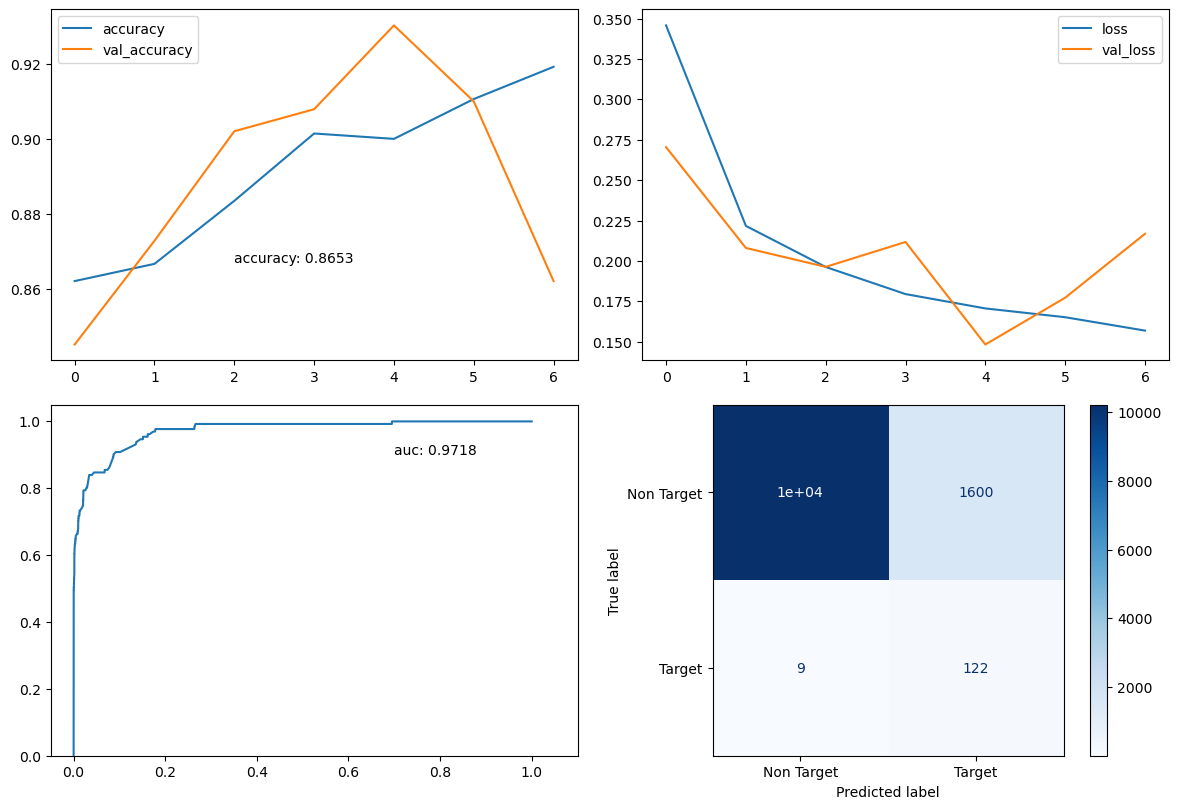

In [4]:
kw = {
    'input_df': input_df,
    'parent_disease': 'MESH:D019636', # neurodegenerative diseases
    'gene_count': 100,
    'show_plots': True,
    'use_class_weights': True,
    'oversample': False
}
dc = DiseaseClassifier(**kw)
dc_mm, _ = dc.main()
display(pd.DataFrame([dc_mm]))

## Oversampling

374/374 [==============================] - 1s 1ms/step


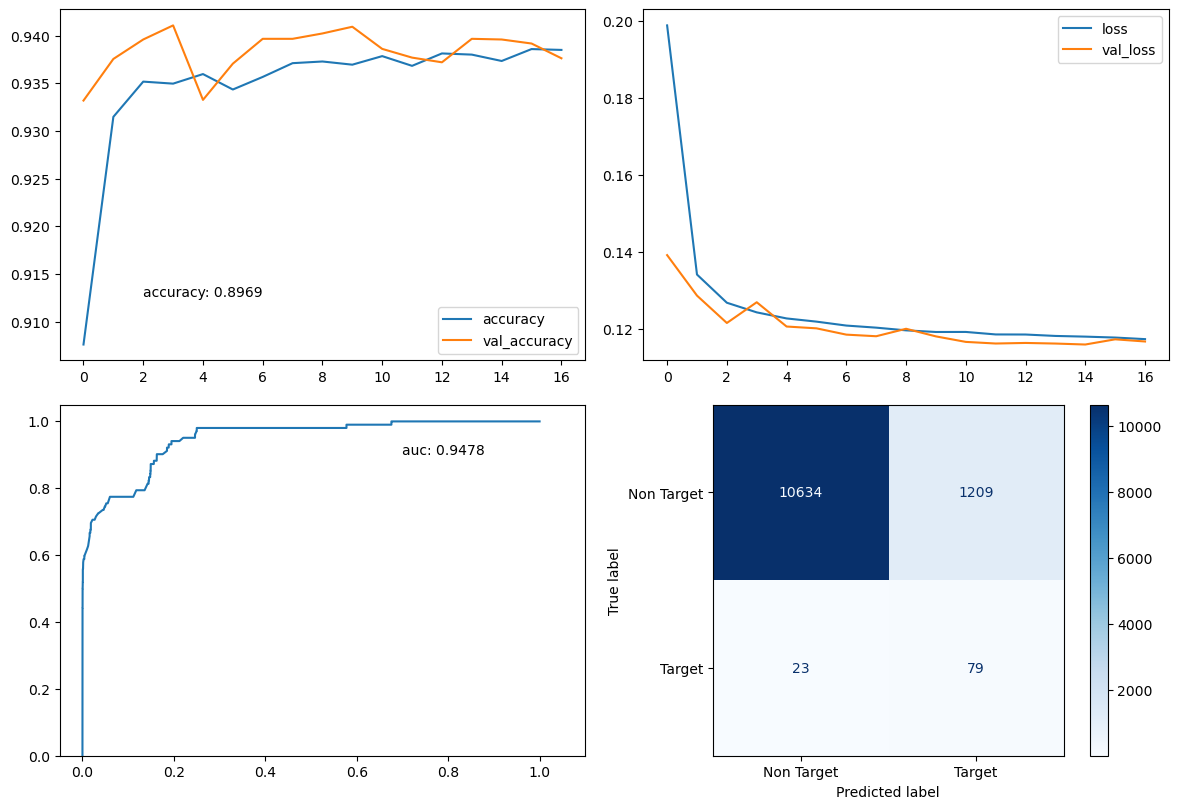

In [3]:
kw = {
    'input_df': input_df,
    'parent_disease': 'MESH:D019636', # neurodegenerative diseases
    'gene_count': 100,
    'show_plots': True,
    'use_class_weights': False,
    'oversample': True
}
dnn_os = DiseaseClassifier(**kw)
mm = dnn_os.main()

## Iterate over a number of different permutations 

In [6]:
# import time
# import json
# import datetime
# from itertools import product

# parent_disease = 'MESH:D019636'
# permutations = []
# for gene_count in range(25, 200, 25):
#     permutations.append({'parent_disease': parent_disease, 'gene_count': gene_count, 'oversample':True, 'use_class_weights': False})
#     permutations.append({'parent_disease': parent_disease, 'gene_count': gene_count, 'oversample':False, 'use_class_weights': True})
#     permutations.append({'parent_disease': parent_disease, 'gene_count': gene_count, 'oversample':False, 'use_class_weights': False})

# results = []
# for i, (p) in enumerate(permutations):
#     p['input_df'] = input_df
#     p['show_plots'] = False
#     _m = DiseaseClassifier(**p)
    
#     model_results, _ = _m.main()
#     with open('out_stream.txt', 'a') as f:
#         f.write(json.dumps(model_results) + '\n')
#     results.append(model_results)

# df = pd.DataFrame(results)

# now = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
# df.to_csv('final-output/{ts}.csv'.format(ts=now))


## what are the best params to use?

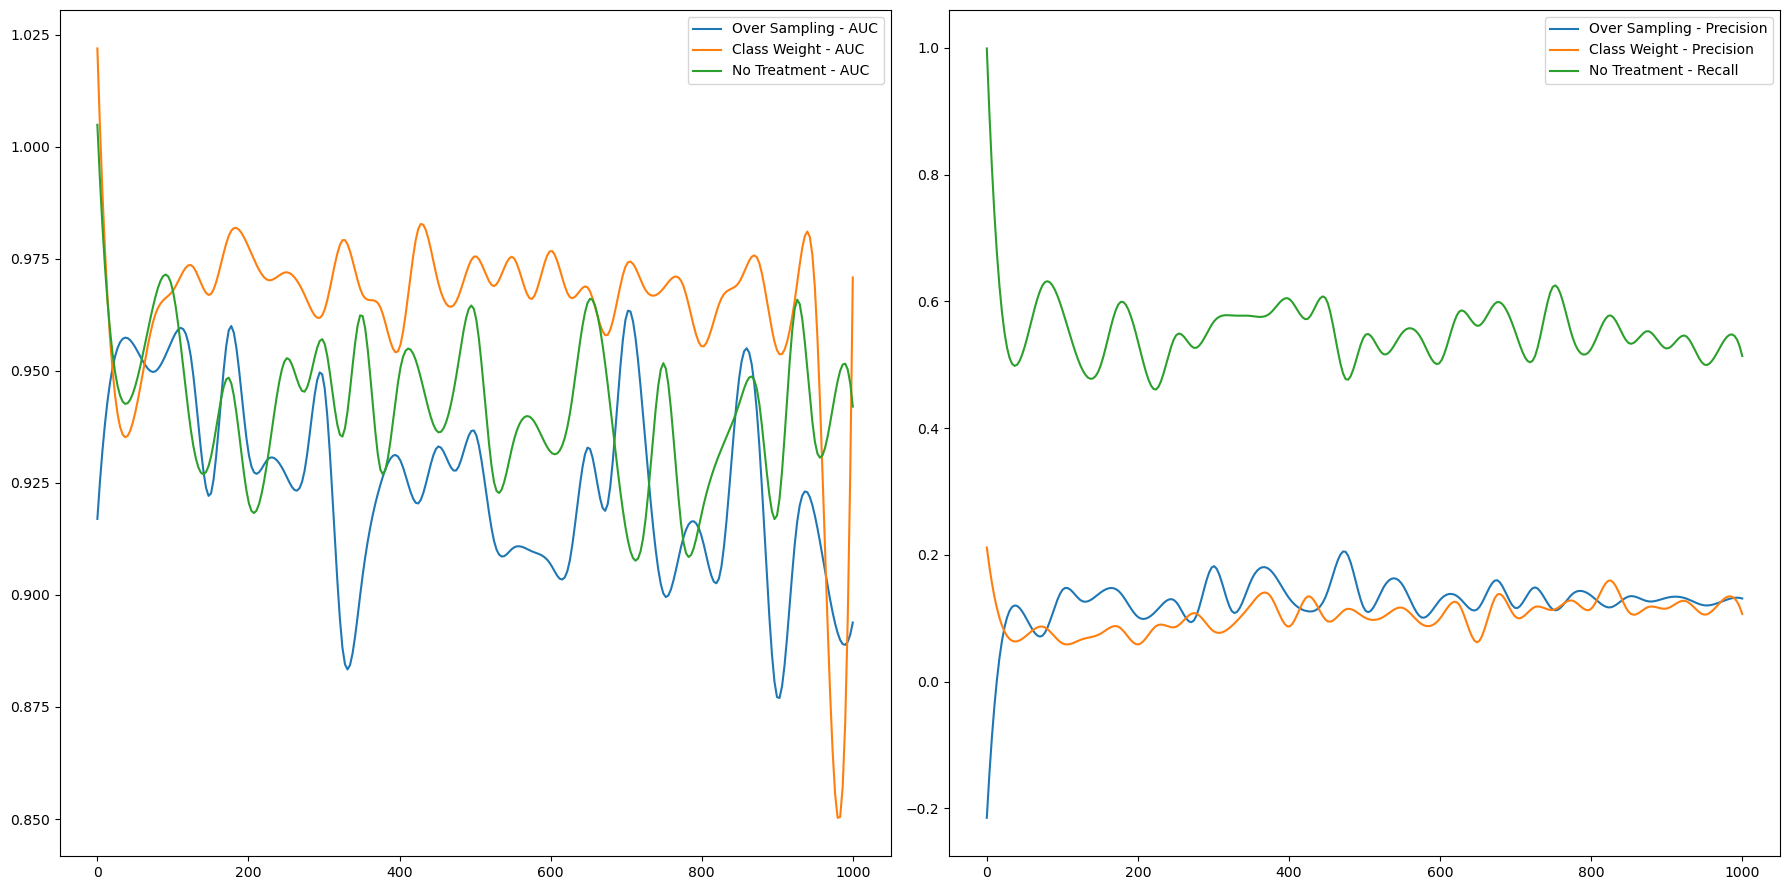

In [9]:
import pandas as pd
import glob

from scipy.interpolate import make_interp_spline, BSpline

csv_files = glob.glob('final-output/*.csv')
csv_files.sort(key=os.path.getmtime, reverse=True)
most_recent_file = csv_files[0]
results_df = pd.read_csv(most_recent_file)
# results_df = pd.read_csv('tmp_output.csv')

# display(results_df.sort_values('recall', ascending=False)[:10])

def get_plot(df, metric):
    x_axis = df['gene_count']
    xnew = np.linspace(0, max(x_axis), 300) 
    spl = make_interp_spline(df['gene_count'], df[metric], k=3)
    power_smooth = spl(xnew)

    return xnew, power_smooth

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 9))
dnn_df = results_df[(results_df['model_type'] == 'DNN')]

oversample_df = dnn_df[dnn_df['oversample']]
class_weight_df = dnn_df[dnn_df['use_class_weights']]
no_treatment_df = dnn_df[(dnn_df['oversample'] == False) & (dnn_df['use_class_weights'] == False)]

axes[0].plot(*get_plot(oversample_df, 'auc'), label='Over Sampling - AUC')
axes[0].plot(*get_plot(class_weight_df, 'auc'), label='Class Weight - AUC')
axes[0].plot(*get_plot(no_treatment_df, 'auc'), label='No Treatment - AUC')
axes[0].legend()

axes[1].plot(*get_plot(oversample_df, 'precision'), label='Over Sampling - Precision')
axes[1].plot(*get_plot(class_weight_df, 'precision'), label='Class Weight - Precision')
axes[1].plot(*get_plot(no_treatment_df, 'recall'), label='No Treatment - Recall')
axes[1].legend()


fig.tight_layout()

## DNN with Multi Class

In [10]:
kw = {
    'input_df': input_df,
    'parent_disease': 'MESH:D019636', # neurodegenerative diseases
    'gene_count': 500,
    'show_plots': True,
    'use_class_weights': False,
    'oversample': True,
    'classification': 'categorical'
}
cat = DiseaseClassifier(**kw)
mm, _ = cat.main()

Exception: Oversampling is not supported with categorical classifications.

### Here we evaluate the chemicals that have posibile therapeutic and harmful effects as it relates to.  We take the chemical to gene network.  I want to see chemicals *not* in the dataset that we can research.

In [ ]:
# instatiate the model to get the relevant genes that we need to process.. dont need to fit the model yet
kw = {
    'input_df': input_df,
    'parent_disease': 'MESH:D019636', # neurodegenerative diseases
    'gene_count': 1000,
    'show_plots': False,
    'oversample': False,
    'use_class_weights': True,
    'classification': 'categorical'
}
dc = DiseaseClassifier(**kw)
chem_cl_metrics, chem_cl_model = dc.main()

inp_df = get_data('ChemicalGeneInteractions')
inp_df = inp_df[inp_df['GeneSymbol'].isin(chem_cl.top_n_genes)]

## process the chemical -> dataset ( without disease ) in the same way we do our input data
gb_df = inp_df.groupby(['ChemicalName', 'GeneSymbol']).size().reset_index()
gb_df.columns = ['ChemicalName','GeneSymbol', 'InteractionCount']
dummy_df = pd.get_dummies(gb_df, prefix='', prefix_sep='',columns=['GeneSymbol'])

chem_df = dummy_df.groupby(['ChemicalName']).agg({np.max}).reset_index()
chem_df.columns = chem_df.columns.droplevel(1)

predicted_values = chem_cl_model.predict(chem_df[chem_cl.top_n_genes])

predicted_value_df = pd.DataFrame(predicted_values, columns=['Ther', 'Not Relevant', 'Marker'])

final = chem_df.merge(predicted_value_df, left_index=True, right_index=True)
final = final[['ChemicalName', 'Ther', 'Not Relevant', 'Marker']]

print('--- THER ---')
display(final.nlargest(5, 'Ther'))

print('--- MARKER ---')
display(final.nlargest(5, 'Marker'))

# chem_df[:4]

In [ ]:
## ctd says (+)-JQ1 compound	 is associated with the reduction of inflamation
## pub chem says trimethyllead is acutely toxic - https://pubchem.ncbi.nlm.nih.gov/compound/Trimethyllead-acetate is ""

## Understanding feature importance -- what genes are coorelated with Parkinsons / Neurodegenerative diseass

In [ ]:

from sklearn.ensemble import RandomForestClassifier


def feature_importance(features, labels, stop_early=True, show_plots=True):
    input_shape = features.shape[1]
    
    X_train, X_test, y_train, y_test = train_test_split(features, labels, random_state=0, train_size=TRAIN_SIZE)

    rand_forest_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
    rand_forest_classifier.fit(X_train, y_train)

    optimal_node_count = 128
    feature_count = 70
    output_label_len = 10
    imp_arr = rand_forest_classifier.feature_importances_
    
    gene_importance = dict(zip(features.columns, imp_arr))
    gene_importance_df = pd.DataFrame({'gene': features.columns, 'score': imp_arr})

    return gene_importance_df.sort_values('score', ascending=False)

## Gene Importance for Neurodegenrative Diseases

In [ ]:
train_df = chem_cl.prep_training_data()
train_df = chem_cl.set_label(train_df)

gene_columns = train_df.columns.intersection(chem_cl.top_n_genes)

print(len(gene_columns))
shuffled_df = train_df.sample(frac=1)

gene_importance_df = feature_importance(shuffled_df[gene_columns], shuffled_df['binary_label'])

gene_importance_df.hist()

ax = gene_importance_df[:20].plot.bar(y='score', x='gene', rot=0, figsize=(20,10))

## Gene Importance for Parkinsons

In [ ]:
kw = {
    'input_df': input_df,
    'parent_disease': 'MESH:D010300', # parkinsons diseases
    'gene_count': 1000,
    'model_type':'DNN',
    'show_plots': False,
    'oversample': True,
    'use_class_weights': False,
    'classification': 'binary'
}
park_cl = DiseaseClassifier(**kw)
results, park_model = park_cl.main()


train_df = park_cl.prep_training_data()
train_df = park_cl.set_label(train_df)

gene_columns = train_df.columns.intersection(park_cl.top_n_genes)

shuffled_df = train_df.sample(frac=1)

park_gene_importance_df = feature_importance(shuffled_df[gene_columns], shuffled_df['binary_label'])

## https://www.nature.com/articles/ng0892-345 # APP shows up... has strong inference to alzheimers
ax = park_gene_importance_df[:20].plot.bar(y='score', x='gene', rot=0, figsize=(20,10))
